# Homework 1

#### Volkov Dmitry
 
Download Microsoft stock price data for a period of `2017-07-01`,`2020-06-30` and calculate VaR curves using different approaches:

1. Use GARCH model with constant mean, EGARCH(2, 1, 2) and skewed t-student distribution of residuals
2. Use Generalized normal distribution (check this documenation https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gennorm.html)
3. Use a combination of GARCH and EVT: filter time series with GARCH and then model residuals with Excess Distribution Over a Threshold (hint: you need to take calculate_VaR_FHS() and "insert" a code from EVT section to the middle)


Then plot all VaR curves on one graph and conduct tests to select the most convenient approach. Finally, you should deliver:
1. One graph with daily historical returns and VaR curves
2. p-value for each model you use
3. Conclusion about what approach is the most suitable for this stock

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as ss

plt.rcParams['figure.dpi'] = 200
plt.style.use("bmh")

import warnings
warnings.filterwarnings("ignore")

#### Load data

In [2]:
TICKER = 'MSFT'
start = '2017-07-01'
end = '2020-06-30'
prices = yf.download(TICKER, start, end)
prices.index = prices.index.to_period(freq='d')
price = prices['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
ret_log = np.log(price).diff().dropna()
ret = price.pct_change().dropna()

In [4]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)  
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [5]:
alpha = 0.05

---

## 1.1 Use GARCH model
* constant mean,
* EGARCH(2, 1, 2)
* skewed t-student distribution of residuals

In [6]:
from arch import arch_model 

In [7]:
# fit the model with normal ditribution

def calculate_VaR_EGARCH(returns, alpha):
    
    scaling_const = 1000.0 / returns.std()

    am = arch_model(scaling_const * returns,
                    mean='Constant', lags=1,
                    vol='EGARCH', p=2, o=1, q=2,
                    dist='skewstudent')

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])
    q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_EGARCH_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_EGARCH_forecast

In [8]:
VaR_EGARCH = calc_VaR(ret, calculate_VaR_EGARCH, L_history=252, level=alpha)

/Users/dmitry.volkov/.pyenv/versions/3.8.6/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/dmitry.volkov/.pyenv/versions/3.8.6/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/dmitry.volkov/.pyenv/versions/3.8.6/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [9]:
VaR_EGARCH[VaR_EGARCH == VaR_EGARCH.min()] = 0 # Impute the outlier

## 1.2 Use Generalized normal distribution

In [10]:
def calculate_VaR_generalized(ret, alpha=0.05):
    return ss.gennorm.ppf(alpha, *ss.gennorm.fit(ret))

In [11]:
VaR_generalized = calc_VaR(ret, calculate_VaR_generalized, L_history=252, level=alpha)

## 1.3 Combination of GARCH and EVT
Filter time series with `GARCH` and then model residuals with Excess Distribution Over a Threshold (hint: you need to take `calculate_VaR_FHS()` and "insert" a code from `EVT` section to the middle)

In [12]:
def calculate_VaR_FHS_EVT(ret, alpha=0.05):
    scaling_const = 10.0 / ret.std()

    mdl = arch_model(scaling_const * ret,
                        mean='HARX', lags=1,
                        vol='Garch', p=1, o=1, q=1,
                        dist='normal')
    res = mdl.fit(disp='off')

    # get Standartized residuals
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()

    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const
    
    # working with residuals using pareto
    u = conditional_sr.quantile(0.25)
    ret_tail = conditional_sr[conditional_sr <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    VaR_FHS_EVT_forecast = -abs(u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1))

    return VaR_FHS_EVT_forecast


In [13]:
VaR_FHS_EVT = calc_VaR(ret, calculate_VaR_FHS_EVT, L_history=252, level=alpha)

---

# 2.1 Graph with daily historical returns and VaR curves

In [20]:
ret

Date
2017-07-03   -0.011026
2017-07-05    0.013349
2017-07-06   -0.007383
2017-07-07    0.012979
2017-07-10    0.007486
                ...   
2020-06-23    0.006681
2020-06-24   -0.020157
2020-06-25    0.012636
2020-06-26   -0.020016
2020-06-29    0.010747
Freq: D, Name: Adj Close, Length: 753, dtype: float64

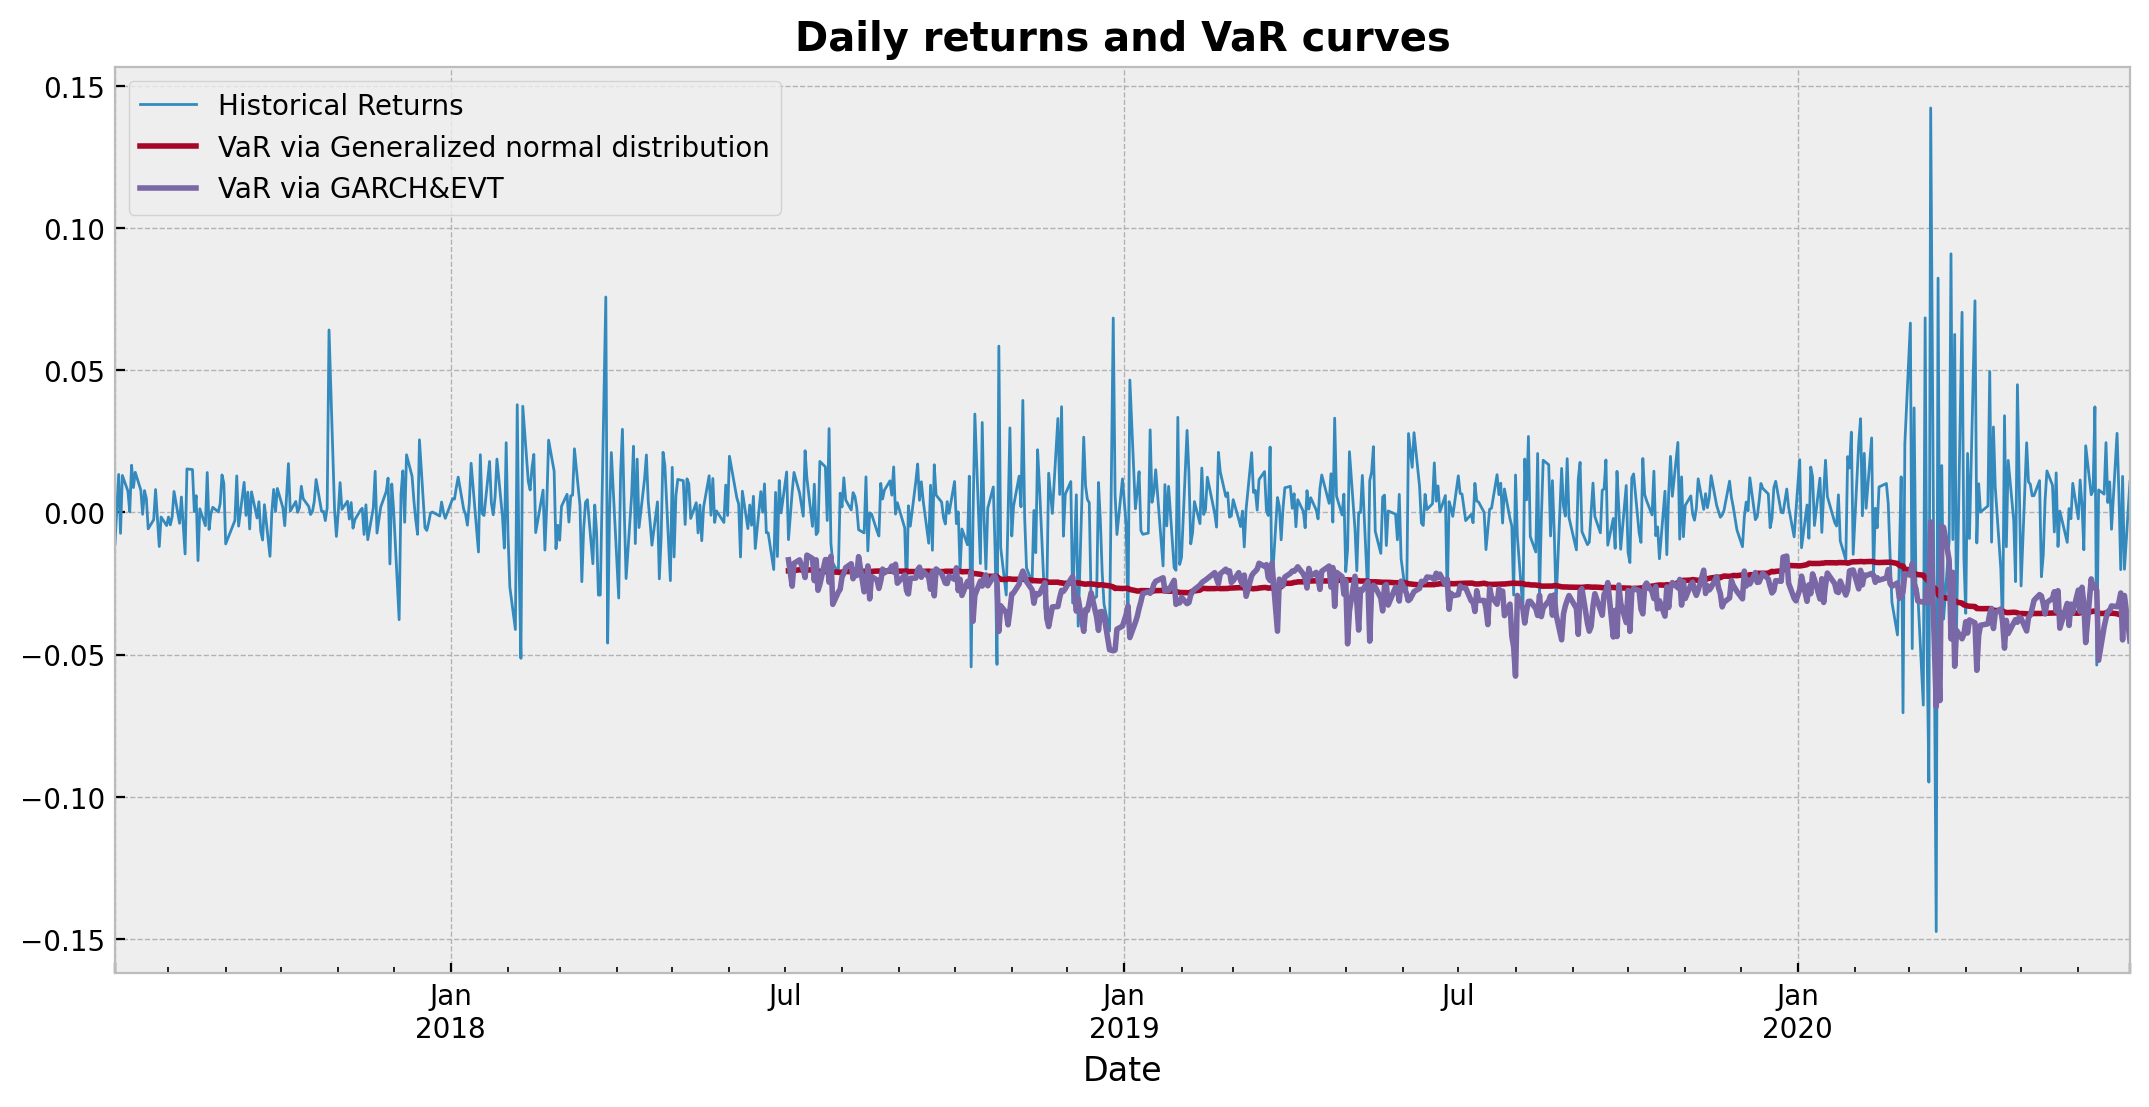

In [19]:
fig = plt.figure(figsize=(13, 6))
ret.plot(label = 'Historical Returns', linewidth=1, )

# VaR_EGARCH.plot(label = 'VaR via EGARCH', linewidth=1)

VaR_generalized.plot(label = 'VaR via Generalized normal distribution', linewidth=2)

VaR_FHS_EVT.plot(label = 'VaR via GARCH&EVT')


plt.title("Daily returns and VaR curves", weight="bold")

plt.legend()
plt.show()

---

## 2.2 p-value for each model we used

In [15]:
def calc_hits(ret, VaRs):
    return ((VaRs - ret).dropna() > 0).values

def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

def backtest_VaR(ret, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0]
    ret = ret[L:]
    VaR = VaR[L:]
    hits = calc_hits(ret, VaR)
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

#### EGARCH

In [16]:
backtest_VaR(ret, VaR_EGARCH, 1-alpha)

Backtesting calculate_VaR_EGARCH:
The proportion of hits is 6.39% instead of expected 5.0%
Two-sided p-val 0.151, one-sided: 0.0963
green zone



#### Generalized normal distribution

In [17]:
backtest_VaR(ret, VaR_generalized, 1-alpha)

Backtesting calculate_VaR_generalized:
The proportion of hits is 7.78% instead of expected 5.0%
Two-sided p-val 0.0073, one-sided: 0.00476
yellow zone



#### Combination of GARCH & EVT

In [18]:
backtest_VaR(ret, VaR_FHS_EVT, 1-alpha)

Backtesting calculate_VaR_FHS_EVT:
The proportion of hits is 5.19% instead of expected 5.0%
Two-sided p-val 0.837, one-sided: 0.451
green zone



---

## 2.3 Conclusion about what approach is the most suitable for this stock

From the presented results combination of filtering time series via GARCH followed with modelling of residuals using Excess Distribution Over a Threshold `(GARCH&EVT)` lead to superiorly better values of hit proportions `5.39%` and a much higher p-value compare to EGARCH and General Normal distribution modelling.

Even though this approach might be additionally tuned with respect to the threshold of tail modelling (in this case was chosen `25th` quantile).

Tests of two other methodologies demonstrated satisfying performance of `6.39%` and `7.78%` of hits proportion, respectively, and quite lower p-values.

To sum up, we may consider `GARCH&EVT` model the most reliable in case of value at risk modelling for Microsoft stock prices.

---